In [1]:
import os
import json
import torch
import random
import pymongo
import numpy as np

from scipy import interpolate
from datetime import datetime
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

from deep_fields import data_path
from deep_fields.data.crypto.create_dataset_files import create_merged_dataframe, read_and_fix
from deep_fields.data.crypto.dataloaders import CryptoDataLoader

In [2]:
date_string = "2021-06-14"
crypto_folder = os.path.join(data_path, "raw", "crypto")
data_folder = os.path.join(crypto_folder, date_string)
initial_date = datetime(2015, 1, 1)
final_date = datetime.strptime(date_string, "%Y-%m-%d")
        
kwargs = {"path_to_data":data_folder,
          "batch_size": 29,
          "date_string":date_string,
          "steps_ahead":10,
          "span":"full"}

crypto_data_loader = CryptoDataLoader('cpu', **kwargs)

In [3]:
path_to_data = data_folder
span = "full"
ds_type = "train"
ecosystem_train = torch.Tensor(np.load(os.path.join(path_to_data, '{0}_ecosystem_{1}.npy'.format(span,ds_type))))
ecosystem_index_train = torch.Tensor(np.load(os.path.join(path_to_data, '{0}_index_ecosystem_{1}.npy'.format(span,ds_type)))).long()

ds_type = "val"
ecosystem_val = torch.Tensor(np.load(os.path.join(path_to_data, '{0}_ecosystem_{1}.npy'.format(span,ds_type))))
ecosystem_index_val = torch.Tensor(np.load(os.path.join(path_to_data, '{0}_index_ecosystem_{1}.npy'.format(span,ds_type)))).long()

ds_type = "test"
ecosystem_test = torch.Tensor(np.load(os.path.join(path_to_data, '{0}_ecosystem_{1}.npy'.format(span,ds_type))))
ecosystem_index_test = torch.Tensor(np.load(os.path.join(path_to_data, '{0}_index_ecosystem_{1}.npy'.format(span,ds_type)))).long()

ecosystem_meta = json.load(open(os.path.join(path_to_data, '{0}_meta_ecosystem.json'.format(span)), "r"))

ecosystem_pmv = torch.cat([ecosystem_train,ecosystem_test,ecosystem_val],axis=0)
ecosystem_index = torch.cat([ecosystem_index_train,
                             ecosystem_index_test,
                             ecosystem_index_val])

In [5]:
ecosystem_train.shape

torch.Size([4883, 2358, 3])

In [4]:
ecosystem_index_train.shape

torch.Size([4883])

In [8]:
survival_times_ = {}
id_to_proportion = {}
id_proportion = []
name_to_birth = {}
ALL_PROPORTIONS = []

for i,a in enumerate(ecosystem_meta):
    survival_time = a['survival_time']
    not_nans = a['not_nans']
    proportion = not_nans/float(survival_time)
    ALL_PROPORTIONS.append(proportion)
    
    id_to_proportion[i] = proportion
    id_proportion.append((proportion,i))
    name_to_birth[a["id"]] = a["birth_date"]
    
    survival_times_[i] = survival_time
id_proportion.sort()

In [9]:
SELECTED_IDS = [a[1] for a in id_proportion]

SELECTED_IDS_NAMES = [ecosystem_meta[a]['id'] for a in SELECTED_IDS]

birth_dates = [datetime.strptime(ecosystem_meta[a]["birth_date"],"%Y-%m-%d %H:%M:%S") \
               for a in SELECTED_IDS]

last_dates = [datetime.strptime(ecosystem_meta[a]["last_date"],"%Y-%m-%d %H:%M:%S") \
              for a in SELECTED_IDS]

SURVIVAL_TIME = [ecosystem_meta[a]["survival_time"] for a in SELECTED_IDS]

birth_index = [(birth_date - initial_date).days for birth_date in birth_dates]
last_index = [(last_index_ - initial_date).days for last_index_ in last_dates]

In [10]:
len(last_index)

6104

In [21]:
problematic_ids = []
for j,id_ in enumerate(SELECTED_IDS):
    try:
        coin_meta = ecosystem_meta[id_]
        #plt.title("{0}, {1}, {2}".format(coin_meta["id"],coin_meta["symbol"],id_))
        #plt.plot(ecosystem_pmv[id_][birth_index[j]:last_index[j],0])

        coin_meta = ecosystem_meta[id_]
        price = ecosystem_pmv[id_][birth_index[j]:last_index[j]+1,0]
        indexes_full = np.asarray(list(range(birth_index[j],last_index[j]+1)))
        indexes_not_nan = indexes_full[np.where(price != 0.)[0]]
        price = price[np.where(price != 0.)[0]]

        f2 = interp1d(indexes_not_nan,price, kind='cubic')
        price_corrected = f2(indexes_full)
        
        #plt.plot(price_corrected,"-")
        #plt.show()
    except:
        problematic_ids.append(id_)
    
    if j % 500 == 0:
        print(j)


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


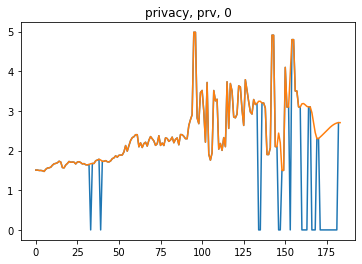

0


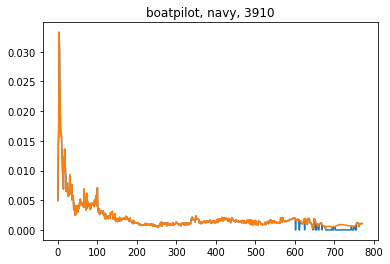

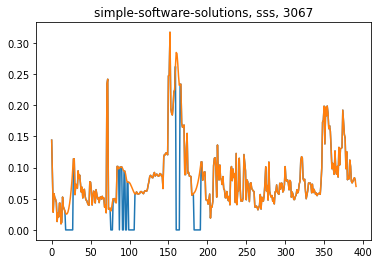

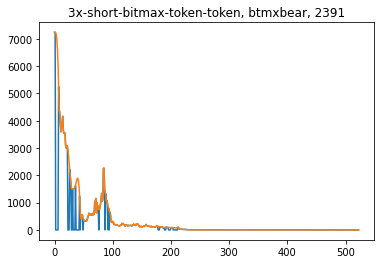

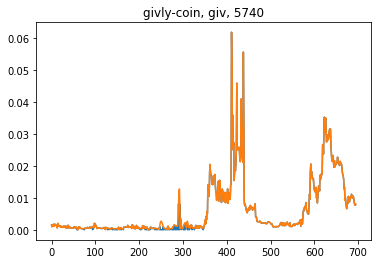

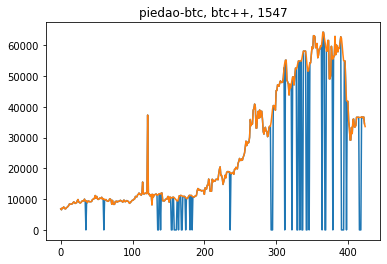

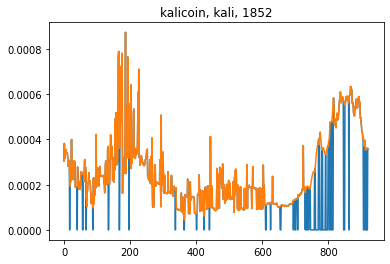

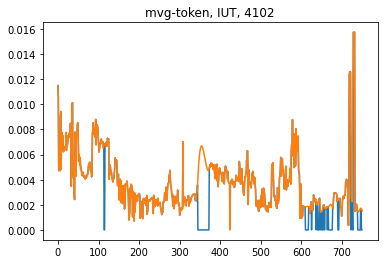

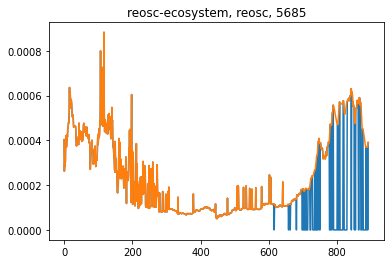

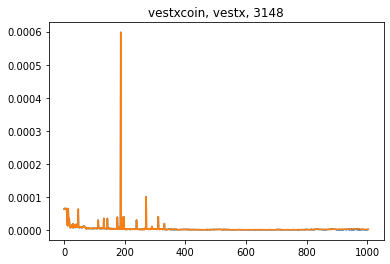

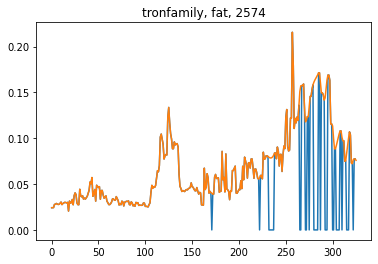

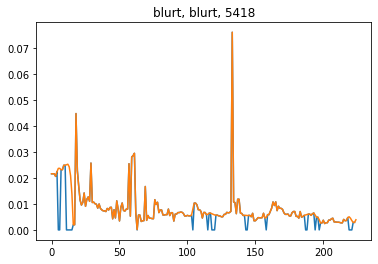

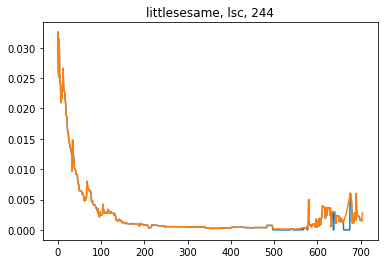

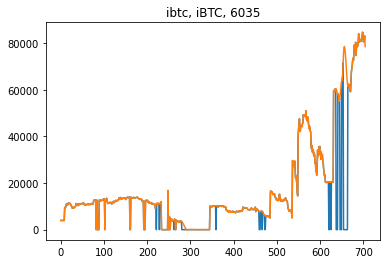

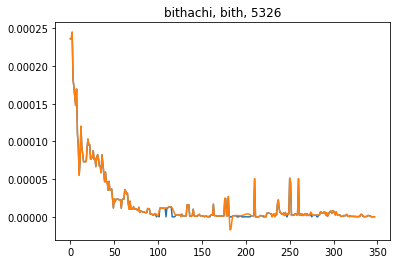

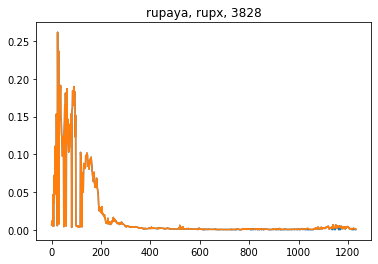

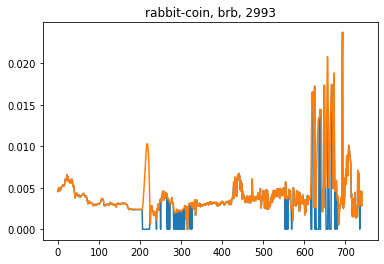

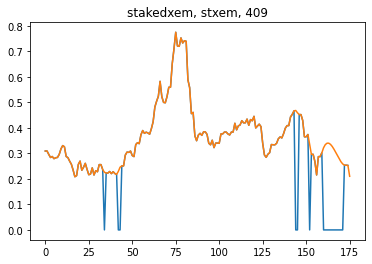

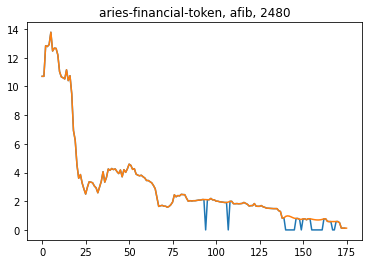

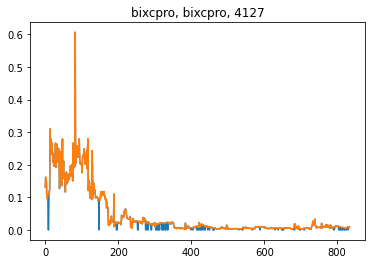

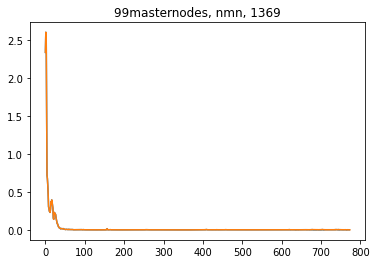

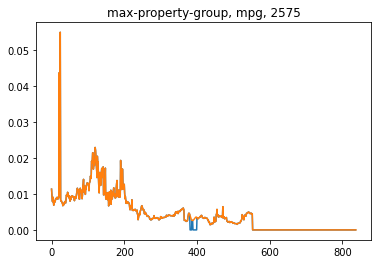

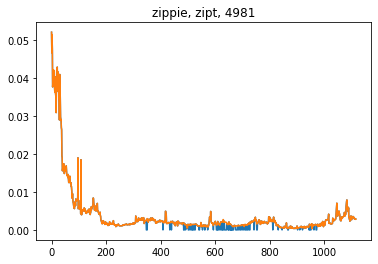

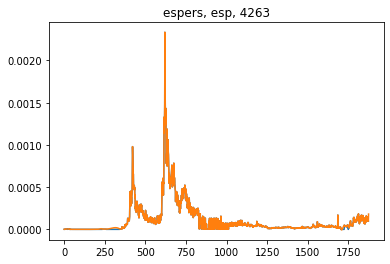

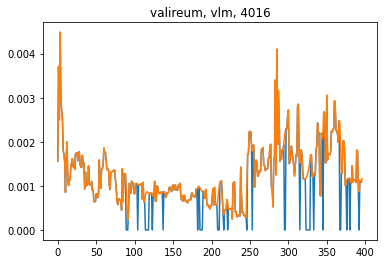

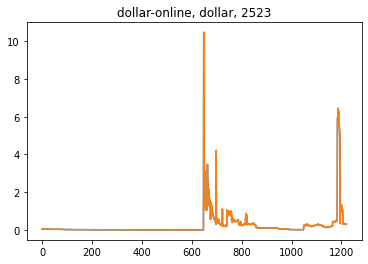

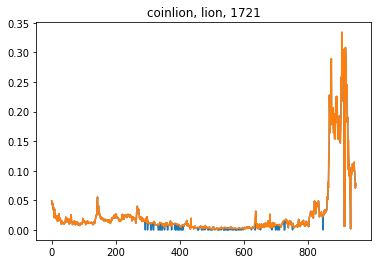

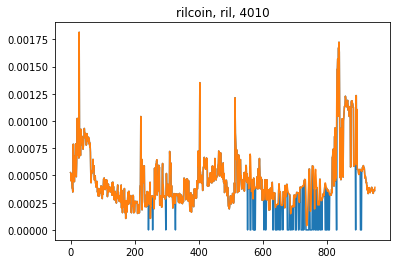

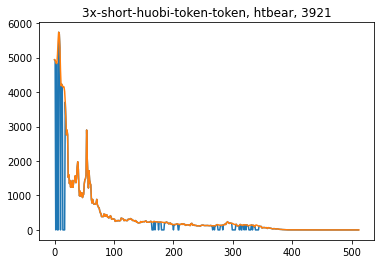

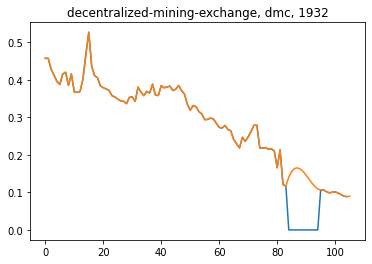

In [12]:
pmv_index = 1
problematic_ids = []
for j,id_ in enumerate(SELECTED_IDS[:30]):
    #try:
    price_not_corrected = ecosystem_pmv[id_][birth_index[j]:last_index[j],pmv_index]
    coin_meta = ecosystem_meta[id_]
    plt.title("{0}, {1}, {2}".format(coin_meta["id"],coin_meta["symbol"],id_))
    plt.plot(price_not_corrected)

    if pmv_index == 0:
        price = ecosystem_pmv[id_][birth_index[j]:last_index[j]+1,pmv_index]

        indexes_full = np.asarray(list(range(birth_index[j],last_index[j]+1)))
        indexes_not_nan = indexes_full[np.where(price != 0.)[0]]
        price = price[np.where(price != 0.)[0]]

        f2 = interp1d(indexes_not_nan,price, kind='cubic')
        price_corrected = f2(indexes_full)

        plt.plot(price_corrected,"-")
        plt.show()
    else:
        price = ecosystem_pmv[id_][:,pmv_index]
        not_zero_price = np.where(price != 0)[0]
        birth_index_ = min(not_zero_price)
        last_index_ = max(not_zero_price)

        indexes_full = np.asarray(list(range(birth_index_,last_index_)))
        print(len(indexes_full))
        indexes_not_nan = indexes_full[np.where(price != 0.)[0]]
        price = price[np.where(price != 0.)[0]]

        f2 = interp1d(indexes_not_nan,price, kind='cubic')
        price_corrected = f2(indexes_full)

        plt.plot(price_corrected,"-")
        plt.show()
            
    #except:
    #    problematic_ids.append(id_)
    #    plt.show()
        
    if j % 500 == 0:
        print(j)

In [45]:
len(problematic_ids)

30

In [272]:
for j,id_ in enumerate(SELECTED_IDS):

    break
price = price.numpy()
#indexes

In [ ]:
def complete_with_interpolation():
    coin_meta = ecosystem_meta[id_]
    price = ecosystem_pmv[id_][birth_index[j]:last_index[j]+1,0]
    indexes_full = np.asarray(list(range(birth_index[j],last_index[j]+1)))
    indexes_not_nan = indexes_full[np.where(price != 0.)[0]]
    price = price[np.where(price != 0.)[0]]

In [281]:
f2 = interp1d(indexes_not_nan,price, kind='cubic')

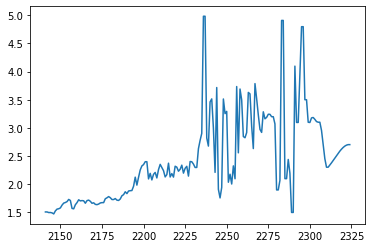

In [282]:
plt.plot(indexes_full, f2(indexes_full))
plt.show()

# Interpolation

In [11]:
x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

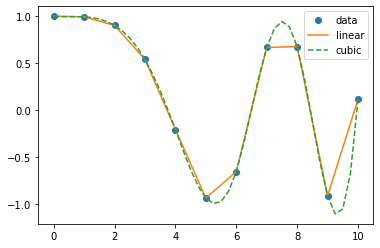

In [12]:
xnew = np.linspace(0, 10, num=41, endpoint=True)
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

# From CoinGecko

In [120]:
from pycoingecko import CoinGeckoAPI
cg=CoinGeckoAPI()

d0_ = datetime(2015, 1, 1)
d0 = int(d0_.timestamp())
df_ = datetime(2021, 6, 14)
df = int(df_.timestamp())

raw_time_series = cg.get_coin_market_chart_range_by_id(id='bitcoinmoney',
                                                       vs_currency='usd',
                                                       from_timestamp=d0,
                                                       to_timestamp=df)

prices_raw_ = np.asarray(raw_time_series["prices"])
marketcap_raw_ = np.asarray(raw_time_series['market_caps'])
total_volumes_ = np.asarray(raw_time_series['total_volumes'])

dates_spand_price = list(map(datetime.fromtimestamp, (prices_raw_[:, 0] / 1000.)))
dates_spand_market = list(map(datetime.fromtimestamp, (marketcap_raw_[:, 0] / 1000.)))
dates_spand_volume = list(map(datetime.fromtimestamp, (total_volumes_[:, 0] / 1000.)))

[dates_spand_price[i+1]-dates_spand_price[i] for i in range(len(dates_spand_price)-1)]

663